# Historical scenarios with fully flexible probabilites

In this notebook, we discuss how we can select historical scenarios based on [Historical Scenarios with Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1696802),

## Relevant packages

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""


from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, correlation_plot, fan_chart

# Views
from codelib.statistics.fully_flexible_views import ProbabilitySolver, CorrelationView,MeanView, VolatilityView, weighted_percentile
from codelib.statistics.fully_flexible_views import effective_sample_size_entropy, calculate_correlation, View

# sta
from codelib.statistics.moments import calculate_correlation, calculate_variance, calculate_std, calculate_covariance, weighted_percentile


## Overview

Make table of content

## Scenario based risk management

We consider the case where the market is driven by $N$ market invariants $X_1, ..., X_N$ such that the PnL $\Pi$ of each security can be written as a function of these market invariants

$$
\Pi = \pi (\mathbf{X})
$$

Typically, risk management is concerned with estimating the joint probability density function of the risk drivers $f_{\mathbf{X}}$ and using it to analyse the PnL, e.g. tail properties. We will often apply either a __parametric approach__ where we assume a particular distribution for the risk drivers or a __scenario-based approach__ where we use the empirical distribution function. 

We will now look at the generalized empirical distribution function by associating non-equal probabilities to different scenarios. 

We can represent the historical observations of the risk drivers by a $T \times N$ panel of joint scenarios $\{x_{t,n}\}$ such that $\mathbf{x}_t = (x_{t,1}, ..., x_{t,N})$ is a 1-dimensional vector of the risk drivers at time $t$. We assume that $\mathbf{x}_t$ is an independent joint scenario from the distribution $f_{\mathbf{X}}$ and each scenario occurs with constant probability $p_t = 1 / T$. 

Based on the $T$ scenarios, we can calculate PnL for the instrument / portfolio under consideration (for each scenario)

$$
\pi_t = \pi(\mathbf{x}_t), \; \; t = 1, ..., T
$$

From these PnLs, we can easily calculate relevant risk measures. 

We seek to extend the flexibility of the scenario-based approach by changing the probabilities $p_t$ associated with the scenarios allowing for more weight on more recent observations, etc. We define the generalized empirical distribtution function as 

$$
f_{\mathbf{X}} = \sum_{t=1}^T p_t \delta^{(\mathbf{x}_t)}
$$

where $\delta^{(\mathbf{x})}$ is the Dirac delta centered in the generic point $\mathbf{z}  \in \mathbb{R}^N$, i.e. takes the value one when $\mathbf{z} = \mathbf{x}$.

### Rolling window 

A simple and often applied modification of the probabilites $p_t, \; t=1,...,T$ is to assume them to be constant over some time interval such that ($\propto$ means proportional to)

$$
p_t \propto \left \{ \begin{array}{ll} 1 & \text{if } \underline{t} \leq t \leq \overline{t} \\ 0 & \text{otherwise} \end{array} \right.
$$

The probabilities must be rescaled such that 

$$
\sum_{t=1}^T p_t = 1
$$

Below we implement a function which calculates the probabilities corresponding to a rolling window. 

In [2]:
def rolling_probs(x: np.ndarray, num_periods: int, last_index: int = None, axis: int = 0) -> np.ndarray:
    """
    Creates an array of equal weights.

    Parameters
    ----------
    x:
        Array for setting the shape of.
    num_periods:
        Number of periods to assign probabilites. 
    last_index: 
        Index of period that will be the last period we assign a positive probability. 
        Default is the index of the last period. 
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    if axis == 0:
        num_obs = x.shape[0]
    elif axis == 1:
        num_obs = x.shape[1]
    else:
        raise IndexError("Axis parameter is invalid, must be either 0 or 1")
        
    if last_index is None:
        idx_end = num_obs
    else:
        idx_end = min(num_obs, last_index + 1)
        
    idx_start = max(idx_end - num_periods, 0)
    weights = np.zeros(num_obs) 
    weights[idx_start:idx_end] = 1 / (idx_end - idx_start)
        
    return weights

__Example: SP500__

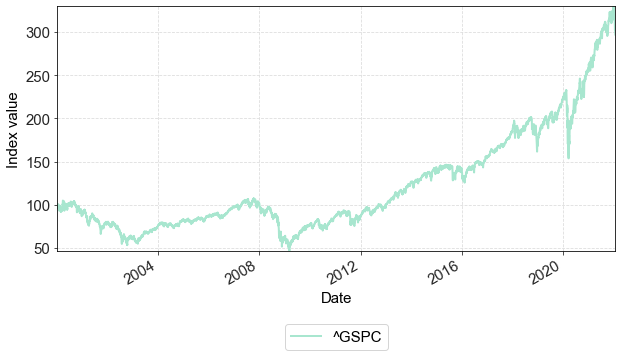

In [3]:
from pandas_datareader.yahoo.daily import YahooDailyReader

"""
Get adjusted index prices for SP500.
"""
tickers = ["^GSPC"]
sp500 = YahooDailyReader(tickers, start=datetime.date(2000, 1, 1)).read()

"""
Get adjusted close and normalize
"""
sp500_adj_close = sp500['Adj Close']
sp500_adj_close = sp500_adj_close / sp500_adj_close.iloc[0, :] * 100

"""
Plot stock prices
"""

ax = sp500_adj_close.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

In [4]:
"""
Calculate log return
"""
sp500_adj_log_ret = np.log(sp500_adj_close / sp500_adj_close.shift(1)).dropna()

In [5]:
"""
Calculate mean with full sample
"""

np.average(sp500_adj_log_ret.values)

0.00019597034606067662

In [6]:
"""
Calculate mean with the last 750 observations
"""

probs_roll = rolling_probs(sp500_adj_log_ret.values, num_periods=750) 

np.average(sp500_adj_log_ret.iloc[:, 0], weights=probs_roll)

0.0006113189136048066

### Exponential Smoothing

A typical use case for exponential smoothing is for estimating parameters in a parametric Monte Carlo simulation. One will use an exponential filter to estimate the expected values, $\boldsymbol{\mu}^{\lambda}$,  and covariance matrix, $\boldsymbol{\Sigma}^{\lambda}$, of the risk drivers and assume $\mathbf{X} \sim N(\boldsymbol{\mu}^{\lambda}, \boldsymbol{\Sigma}^{\lambda})$. More specifically, 


$$
\boldsymbol{\mu}^{\lambda} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t
$$

and 

$$
\boldsymbol{\Sigma}^{\lambda} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t \mathbf{x}_t^\top  - \boldsymbol{\mu}^{\lambda} (\boldsymbol{\mu}^{\lambda})^\top
$$

where $\gamma = 1 /  \sum_{t=1}^T e^{-\lambda (T-t)}$ to make the weights sum to one. $\lambda$ controls the decay of the exponential filter. A $\lambda=0.0055$ will represent a half-life of approximately six months with daily data. 

However, we will be able to specify the PnL distribution without applying Monte Carlo simulations with a particular distributional assumption. We can simply set $p_t$ equal to the exponential decay factor (we need to account for a scaling factor)

$$
p_t \propto e^{-\lambda (T-t)}
$$

such that more recent scenarios are more likely. 

Below we implement a function that calculates the exponential probabilities. 

In [7]:
def exponential_probs(x: np.ndarray, decay: float, last_index: int = None, axis: int = 0) -> np.ndarray:
    """
    Creates an array of equal weights.

    Parameters
    ----------
    x:
        Array for setting the shape of.
    decay:
        Exponential decay factor. 
    last_index: 
        Index of period that will be the last period we assign a positive probability. 
        Default is the index of the last period. 
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    if axis == 0:
        num_obs = x.shape[0]
    elif axis == 1:
        num_obs = x.shape[1]
    else:
        raise IndexError("Axis parameter is invalid, must be either 0 or 1")
        
    if last_index is None:
        idx_end = num_obs
    else:
        idx_end = min(num_obs, last_index + 1)
        
    idx_start = 0 
    
    weights = np.zeros(num_obs) 
    
    weights[idx_start:idx_end] = np.flip(np.exp(-decay * np.arange(idx_end)))
    weights[idx_start:idx_end] /= np.sum(weights)
    
    return weights

__Example: SP500__

In [8]:
"""
Calculate exponential probabilites corresponding to a half-life of  126 days
"""
decay = 0.0055
probs_exp = exponential_probs(sp500_adj_log_ret, decay=decay)

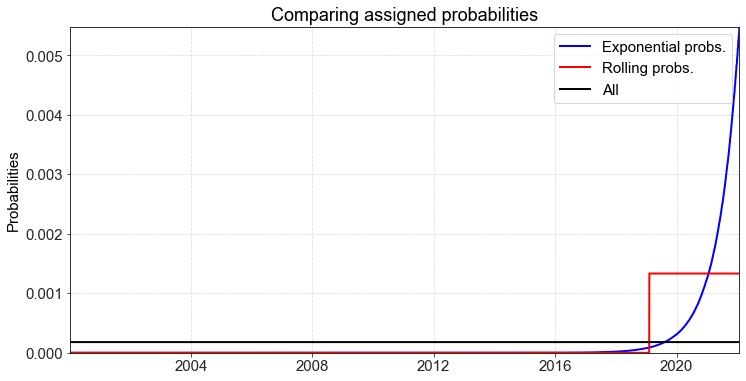

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sp500_adj_log_ret.index, probs_exp, label="Exponential probs.", color="blue");
ax.plot(sp500_adj_log_ret.index, probs_roll, label="Rolling probs.", color="red")
ax.plot(sp500_adj_log_ret.index, np.ones_like(probs_exp) / len(probs_exp), label="All", color="black")
ax.set_ylabel("Probabilities")
ax.set_title("Comparing assigned probabilities");
ax.legend();

In [10]:
print("half-time of {:.2f} days".format(np.log(2) / decay))

half-time of 126.03 days


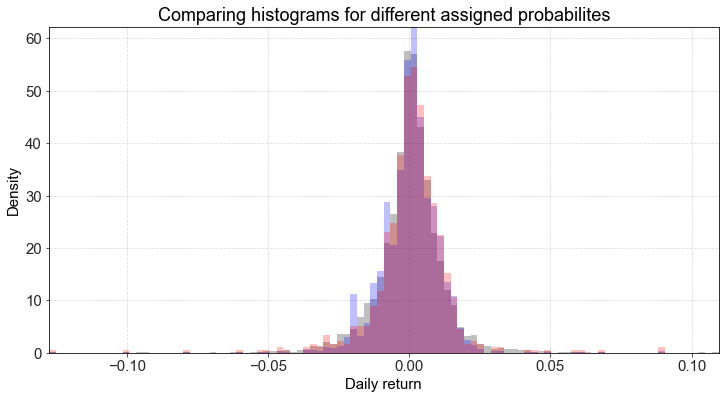

In [11]:
"""
Comparing histograms before and after exponential probabilities
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25, color="black", density=True, label="All");
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25,
        weights=probs_exp, color="blue", density=True, label="Exponential probs.");
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25,
        weights=probs_roll, color="red", density=True, label="Rolling probs.");

ax.set_xlabel("Daily return")
ax.set_ylabel("Density")
ax.set_title("Comparing histograms for different assigned probabilites");

### Market conditioning

__Crisp conditioning__

So far, we have defined "closeness" in terms of time such that we have selected scenarios based on when they have occured. However, it may also be relevant to define scenarios based one macroeconomic state variables. For instance, we may want to select scenarios where a macroeconomic variable $Y$ is inside some region $\mathcal{Y}$:


$$
p_t \propto \left \{ \begin{array}{ll} 1 & \text{if } y_t \in \mathcal{Y} \\ 0 & \text{otherwise} \end{array} \right.
$$

Again, we must normalize probabilities such that they sum to one. We may label this way of setting probabilities for __crisp conditioning__ since we assign probability only if the state variable is inside some interval. 

In [12]:
def crisp_conditioning_probs(x: np.ndarray, condition: Tuple = (-np.inf, np.inf), axis: int = 0) -> np.ndarray:
    
    """
    Creates an array of crisp condition probabilities. 
    
    Currently only works for one state variable. 
    
    Parameters
    ----------
    x:
        Array for setting the shape of.
    condition:
        Tuple with lower and upper bound. 
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    probs = (x >= condition[0]) & (x <= condition[1])
    probs = probs / np.sum(probs)
    
    return probs

__Example: SP500 and VIX__

Plot histogram of SP500 daily return when VIX is larger than 30. Also calculate the expected return. 


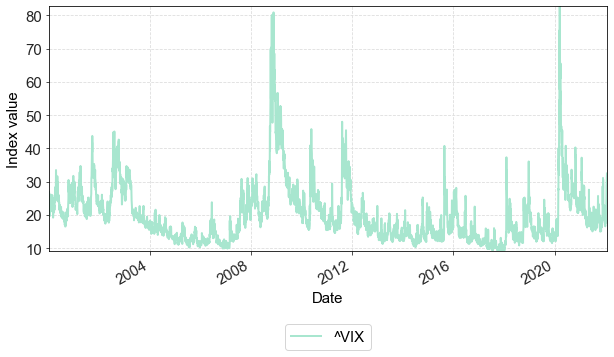

In [13]:
"""
Get VIX index
"""
tickers = ["^VIX"]
vix = YahooDailyReader(tickers, start=datetime.date(2000, 1, 1)).read()['Adj Close']

"""
Plot stock prices
"""

ax = vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

In [14]:
"""
Make sure that dates are the same 
"""

vix = vix.loc[sp500_adj_log_ret.index, :]

In [15]:
"""
Calculate probabilites
"""

probs_crisp = crisp_conditioning_probs(vix.values[:, 0], condition=(30.0, np.inf)) 

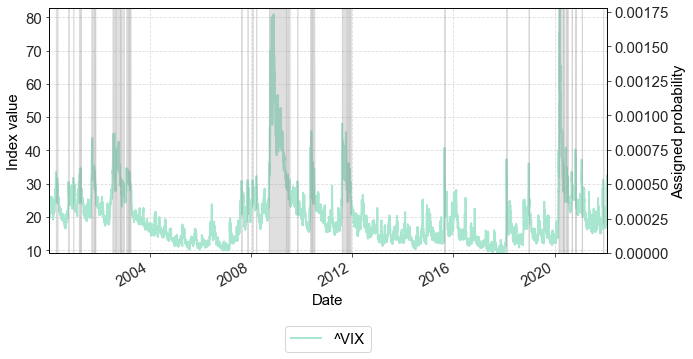

In [16]:
ax = vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

ax_new = ax.twinx()

ax_new.fill_between(vix.index, probs_crisp, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None)

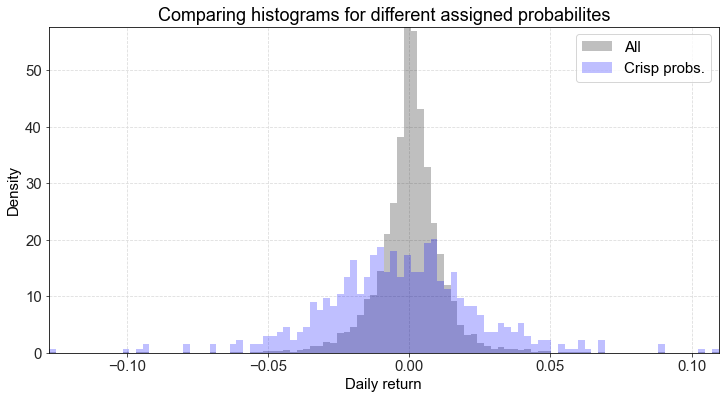

In [17]:
"""
Comparing histograms before and after
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25, color="black", density=True, label="All");
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25,
        weights=probs_crisp, color="blue", density=True, label="Crisp probs.");

ax.set_xlabel("Daily return")
ax.set_ylabel("Density")
ax.set_title("Comparing histograms for different assigned probabilites");
ax.legend();

In [18]:
"""
Expected return - VIX above 30
"""

np.average(sp500_adj_log_ret.values[:, 0], weights=probs_crisp)

-0.0031486275644811127

In [19]:
"""
Expected return
"""

np.average(sp500_adj_log_ret.values[:, 0])

0.00019597034606067662

__Smoothed kernel__

The crisp selection above may be a bit arbitrary in the sense that scenarios with the macroeconomic variable just inside the boundary get assigned full probability while scenarios with the macroeconomic variable just outside the boundary get assigned zero probability. An alternative approach is to use e.g. a normal kernel to define closeness to some target level $\overline{y}$

$$
p_t \propto e^{-(y_t - \overline{y})^2 / 2 s^2}
$$

where $s$ is the volatility or bandwidth which controls the level of smoothing. When $s \to \infty$ then $p_t \to 1 / T$ which corresponds to the unconditional case. Again, we need to normalize the probabilities such that they sum to one. 

In [20]:
def smoothed_conditioning_probs(x: np.ndarray, target: float, std: float, axis: int = 0) -> np.ndarray:
    
    """
    Creates an array of crisp condition probabilities. 
    
    Currently only works for one state variable. 
    
    Parameters
    ----------
    x:
        Array for setting the shape of.
    target: 
        Target value of state variable. 
    std:
        Bandwith.
    axis:
        The axis to create the weights over. Default is 0.

    Returns
    -------
    ndarray
        Array of equal weights.
    """
    
    probs = np.exp(-(x-target)**2 / (2 * std**2))
    probs = probs / np.sum(probs)
    
    return probs

__Example: SP500 and VIX__

Plot histogram of SP500 daily return when VIX is larger than 30. Also calculate the expected return. 


In [21]:
probs_smooth = smoothed_conditioning_probs(vix.values[:, 0], target=30, std=5) 

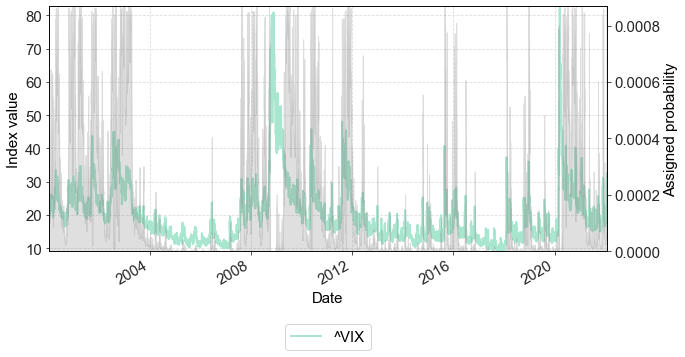

In [22]:
ax = vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

ax_new = ax.twinx()

ax_new.fill_between(vix.index, probs_smooth, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None)

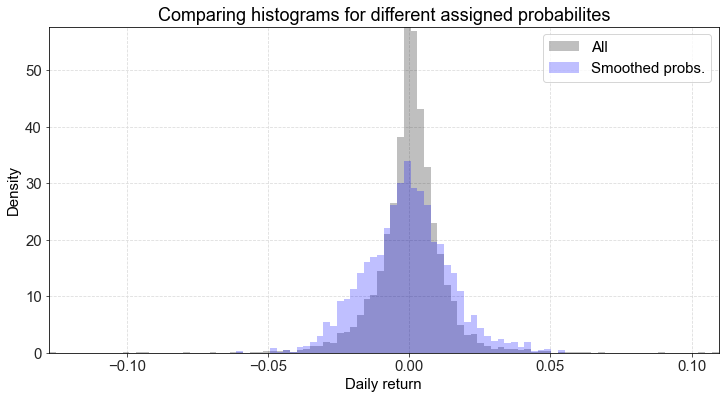

In [23]:
"""
Comparing histograms before and after
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25, color="black", density=True, label="All");
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25,
        weights=probs_smooth, color="blue", density=True, label="Smoothed probs.");

ax.set_xlabel("Daily return")
ax.set_ylabel("Density")
ax.set_title("Comparing histograms for different assigned probabilites");
ax.legend();

### Partial information - fully flexible views

In the above kernel smoothing approach, we used the Gaussian kernel to define closeness to some target $\overline{y}$. We could follow the same approach using different kernels and different choices of the bandwidth parameter. 

An alternative approach is to specify probabilities using the Fully Flexible Views approach of [Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) such that the expected value of the macroeconomc variable is equal to our target. Basically, we want to select a the vector of probabilites $\mathbf{p} = (p_1,...,p_T)^\top$ such that 

$$
\mathbf{p}^\top \mathbf{y} = \sum_{t=1}^T y_t p_t = \overline{y} 
$$

while the distance measured with the relative entropy (also known as Kullback-Leiber divergence) from the reference or prior distribution defined by $q_t = 1/T$ (unconditonal case) is minimized. The relative entrop is defined as

$$
d(p, q) = \sum_{t=1}^T p_t \ln \frac{p_t}{q_t}
$$

Summa summarum, we have the optimization problem 

$$
\mathbf{p}^* = \underset{p}{\text{arg min }} p_t \ln Tp_t \; \; \text{st. } \sum_{t=1}^T y_t p_t = \overline{y} 
$$

which can be solved efficiently using the algorithm presented in [Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325). 


__Example: SP500 and VIX__

In [24]:
"""
Class that implements the above method
"""

init_probs = np.ones_like(vix.values[:, 0])
init_probs = init_probs / np.sum(init_probs)

mean_view = MeanView('eq', vix.values[:, 0], 30)

all_views = [mean_view]

view_solver = ProbabilitySolver(init_probs, all_views)
view_probs = view_solver.minimize_entropy()

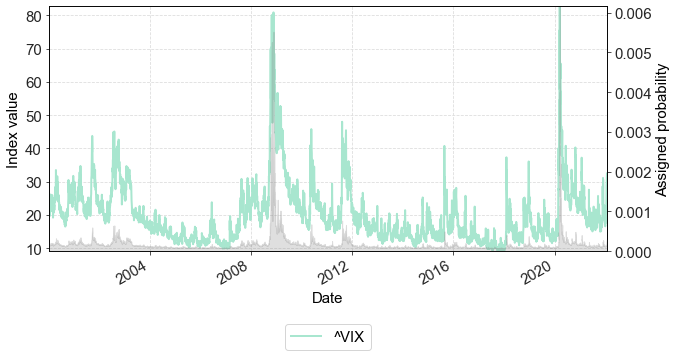

In [25]:
ax = vix.plot(figsize=(10, 5)); 
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5); 
ax.set_ylabel('Index value');

ax_new = ax.twinx()

ax_new.fill_between(vix.index, view_probs, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None)

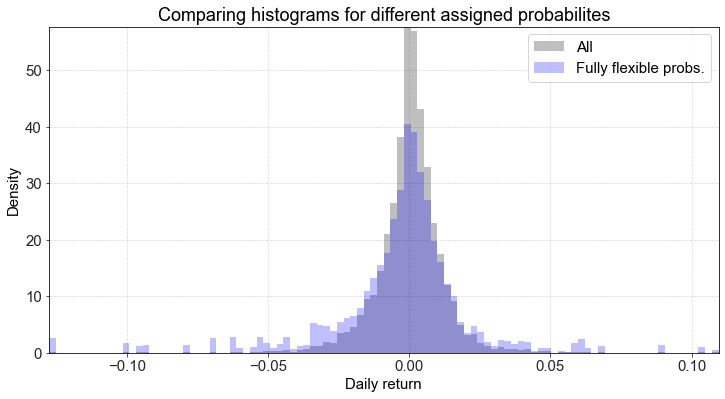

In [26]:
"""
Comparing histograms before and after
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25, color="black", density=True, label="All");
ax.hist(sp500_adj_log_ret.values[:, 0], bins=100, alpha=0.25,
        weights=view_probs, color="blue", density=True, label="Fully flexible probs.");

ax.set_xlabel("Daily return")
ax.set_ylabel("Density")
ax.set_title("Comparing histograms for different assigned probabilites");
ax.legend();

## Literature

[Attilio Meucci (2010), Historical Scenarios with Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1696802)

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325)

[Attilio Meucci (2012), Effective Number of Scenarios in Fully Flexible Probabilities](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1971808)